# Project -Neural Network  
# Street View Housing Number Digit Recognition  
# The Problem Description:
    Recognizing multi-digit numbers in photographs captured at street level is an important component of modernday map 
    making. A classic example of a corpus of such street-level photographs is Google’s Street View imagery comprised of
    hundreds of millions of geo-located 360-degree panoramic images.

In [91]:
# Import required libraries

import h5py
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Activation, Flatten, BatchNormalization, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import optimizers, regularizers
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
#remove warnings
import tensorflow as tf
if type(tf.contrib) != type(tf): tf.contrib._warning = None
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
from tensorflow.python.util import deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn.model_selection import GridSearchCV,cross_val_score,cross_validate
from sklearn.metrics import confusion_matrix,classification_report,f1_score,roc_auc_score,log_loss


In [2]:
# To open and read HDF5 file  
infile = h5py.File('SVHN_single_grey1.h5','r')

In [3]:
# To see what data is in this HDF5 file, we can call the keys() method on the file object.
infile.keys()

<KeysViewHDF5 ['X_test', 'X_train', 'X_val', 'y_test', 'y_train', 'y_val']>

In [4]:
#Load the training, testing, and validation data
X_trainNew = infile['X_train'][:]
X_testNew = infile['X_test'][:]
X_valNew = infile['X_val'][:]
y_trainNew = infile['y_train'][:]
y_testNew = infile['y_test'][:]
y_valNew = infile['y_val'][:]

In [5]:
#Load the back up of training, testing, and validation data
X_train = X_trainNew.copy()
X_test = X_testNew.copy()
X_val = X_valNew.copy()
y_train = y_trainNew.copy()
y_test = y_testNew.copy()
y_val = y_valNew.copy()

In [6]:
print("Shape of X_train : ", X_train.shape,"    Data Type : ",X_train.dtype)
print("Shape of y_train : ", y_train.shape,"           Data Type : ",y_train.dtype)
print("Shape of X_test : ", X_test.shape,"     Data Type : ",X_test.dtype)
print("Shape of y_test : ", y_test.shape,"            Data Type : ",y_test.dtype)
print("Shape of X_val : ", X_val.shape,"      Data Type : ",X_val.dtype)
print("Shape of y_val : ", y_val.shape,"             Data Type : ",y_val.dtype)

Shape of X_train :  (42000, 32, 32)     Data Type :  float32
Shape of y_train :  (42000,)            Data Type :  uint8
Shape of X_test :  (18000, 32, 32)      Data Type :  float32
Shape of y_test :  (18000,)             Data Type :  uint8
Shape of X_val :  (60000, 32, 32)       Data Type :  float32
Shape of y_val :  (60000,)              Data Type :  uint8


In [7]:
# prints first 3 values from X_train - 32X32 array
print(X_train[0][0])
print(X_train[0][1])
print(X_train[0][3])

[33.0704 30.2601 26.852  25.8844 28.5421 33.1673 33.9069 31.277  27.3313
 23.9556 21.3518 22.5258 24.2868 31.2322 37.2917 38.1776 30.8902 24.4887
 27.983  23.3641 19.7774 23.0159 24.7168 24.9941 27.5701 38.5474 52.8341
 65.9037 73.5609 71.4471 58.2204 42.9939]
[ 25.2283  25.5533  29.9765  40.96    54.0358  60.7317  57.5965  47.9611
  33.0103  24.3362  24.3793  33.1997  44.1339  61.1815  80.5278  86.1744
  79.7621  66.5893  47.4926  29.7548  21.8804  22.9943  25.2822  26.6303
  39.7923  64.9531  91.0815 108.8795 113.6079 113.0209 103.3639  84.2949]
[ 32.3478  26.8044  51.4383  87.5396 106.8321 113.38   104.0219  70.8233
  38.3626  24.8415  46.8948  82.9853 107.8966 112.3738  97.9068  93.7331
 108.9227 119.4009 116.9173  89.2128  50.6665  25.2544  25.3899  53.6383
  92.8703 121.9661 121.1557  95.4017  66.5016  75.0554 106.8196 122.5531]


# Data Visualization

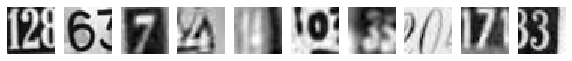

label for each of the above image: [2 6 7 4 4 0 3 0 7 3]


In [8]:
# Visualizing the first 10 images in the dataset and their labels
plt.figure(figsize=(10, 1))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(X_train[i].reshape(32,32), cmap="gray")
    plt.axis('off')
plt.show()
print('label for each of the above image: %s' % (y_train[0:10]))

In [9]:
# prints first 2 records from X_train - 32X32 array
print(X_train[0][0])
print(X_train[0][1])

[33.0704 30.2601 26.852  25.8844 28.5421 33.1673 33.9069 31.277  27.3313
 23.9556 21.3518 22.5258 24.2868 31.2322 37.2917 38.1776 30.8902 24.4887
 27.983  23.3641 19.7774 23.0159 24.7168 24.9941 27.5701 38.5474 52.8341
 65.9037 73.5609 71.4471 58.2204 42.9939]
[ 25.2283  25.5533  29.9765  40.96    54.0358  60.7317  57.5965  47.9611
  33.0103  24.3362  24.3793  33.1997  44.1339  61.1815  80.5278  86.1744
  79.7621  66.5893  47.4926  29.7548  21.8804  22.9943  25.2822  26.6303
  39.7923  64.9531  91.0815 108.8795 113.6079 113.0209 103.3639  84.2949]


# Reshape and one-hot encoding on train, test, validation features

In [10]:
# reshaping X data: (n, 32, 32) => (n, 1024).  
X_train_re = X_train.reshape((X_train.shape[0], -1)) #.reshaped 32*32 array into single dimensional 1024 size array 
X_test_re = X_test.reshape((X_test.shape[0], -1))
X_val_re = X_val.reshape((X_val.shape[0], -1))

In [11]:
print('Number of unique classes: ', len(np.unique(y_train)))
print('Classes: ', np.unique(y_train))

Number of unique classes:  10
Classes:  [0 1 2 3 4 5 6 7 8 9]


In [12]:
# One hot encode the labels for train, test, and validation data
# converting y data into categorical (one-hot encoding)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_val = to_categorical(y_val)

In [13]:
print("Before One hot encoding : ", y_trainNew[0])
print("After One hot encoding  : ", y_train[0])

Before One hot encoding :  2
After One hot encoding  :  [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]


In [14]:
print(X_train_re.shape, X_test_re.shape,X_val_re.shape, y_train.shape, y_test.shape,  y_val.shape)

(42000, 1024) (18000, 1024) (60000, 1024) (42000, 10) (18000, 10) (60000, 10)


In [15]:
print("Minimum value in X_train - ")
print(X_train_re.min())
print("Maximum value in X_train - ") 
print(X_train_re.max())

Minimum value in X_train - 
0.0
Maximum value in X_train - 
254.9745


In [16]:
# Normalize the Train, Validation and Test sets. Get the values in the range of 0 to 1
X_train_reNew = X_train_re / 255.0
X_val_reNew   = X_val_re   / 255.0
X_test_reNew  = X_test_re  / 255.0

In [17]:
print("Minimum & Maximum value after Normalization: ")
print("Minimum value in X_train - ")
print(X_train_reNew.min())
print("Maximum value in X_train - ") 
print(X_train_reNew.max())

Minimum & Maximum value after Normalization: 
Minimum value in X_train - 
0.0
Maximum value in X_train - 
0.9999


## Build neural networks with single hidden layer

In [18]:
print(X_train_reNew.shape, y_train.shape)
print(X_val_reNew.shape,y_val.shape)

(42000, 1024) (42000, 10)
(60000, 1024) (60000, 10)


In [19]:
tf.keras.backend.clear_session()

# Using Adam Optimizer

In [20]:
mod1 = Sequential()
mod1.add(Flatten())
mod1.add(Dense(777, input_shape = (1024,), activation='relu', name='Hidden_Layer_1')) #first hidden layer with 777 neurons, and activation function relu.
mod1.add(Dense(10, activation='softmax', name='Output_Layer')) #output layer with 10 neurons since we have 10 different classes
adam = optimizers.Adam(lr = 0.001)
mod1.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy']) # Adam optimizer is used

In [21]:
history =mod1.fit(X_train_reNew, y_train, batch_size = 200, validation_data=(X_val_reNew,y_val), epochs = 50, verbose = 1) #50 epochs with batch size 200.

Train on 42000 samples, validate on 60000 samples
Epoch 1/50
42000/42000 [==============================] - 7s 155us/sample - loss: 2.3175 - acc: 0.1348 - val_loss: 2.2055 - val_acc: 0.2313
Epoch 2/50
42000/42000 [==============================] - 6s 145us/sample - loss: 1.9841 - acc: 0.3552 - val_loss: 1.7336 - val_acc: 0.5128
Epoch 3/50
42000/42000 [==============================] - 6s 143us/sample - loss: 1.5581 - acc: 0.5416 - val_loss: 1.3967 - val_acc: 0.6076
Epoch 4/50
42000/42000 [==============================] - 6s 143us/sample - loss: 1.3253 - acc: 0.6111 - val_loss: 1.2630 - val_acc: 0.6213
Epoch 5/50
42000/42000 [==============================] - 6s 143us/sample - loss: 1.1985 - acc: 0.6498 - val_loss: 1.1649 - val_acc: 0.6501
Epoch 6/50
42000/42000 [==============================] - 6s 154us/sample - loss: 1.1250 - acc: 0.6699 - val_loss: 1.1070 - val_acc: 0.6608
Epoch 7/50
42000/42000 [==============================] - 6s 153us/sample - loss: 1.0720 - acc: 0.6853 - val_l

In [22]:
history.history['acc']

[0.13478571,
 0.3551905,
 0.5415952,
 0.61109525,
 0.6498333,
 0.66985714,
 0.6852619,
 0.69935715,
 0.7101905,
 0.7205,
 0.7290952,
 0.7328333,
 0.7395238,
 0.74788094,
 0.7557857,
 0.7592857,
 0.7617143,
 0.7680714,
 0.77271426,
 0.7753571,
 0.7805,
 0.7815476,
 0.78638095,
 0.7875,
 0.79359525,
 0.79630953,
 0.7971905,
 0.7999524,
 0.80266666,
 0.80590475,
 0.80557144,
 0.8083095,
 0.81214285,
 0.81378573,
 0.8147143,
 0.8187381,
 0.8191905,
 0.8209286,
 0.8228809,
 0.82464284,
 0.8238095,
 0.8257619,
 0.8252381,
 0.82902384,
 0.83085716,
 0.8325476,
 0.8309762,
 0.8343095,
 0.83433336,
 0.8344762]

In [23]:
mod1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            multiple                  0         
_________________________________________________________________
Hidden_Layer_1 (Dense)       multiple                  796425    
_________________________________________________________________
Output_Layer (Dense)         multiple                  7780      
Total params: 804,205
Trainable params: 804,205
Non-trainable params: 0
_________________________________________________________________


In [24]:
res1= mod1.evaluate(X_test_reNew, y_test)

18000/18000 [==============================] - 2s 133us/sample - loss: 0.6785 - acc: 0.8098


In [25]:
Y_pred_cls = mod1.predict_classes(X_test_reNew, batch_size=200, verbose=0)

print('Accuracy') 
print( str(mod1.evaluate(X_test_reNew,y_test)[1]) )


label=np.argmax(y_test.T, axis=0)
print(confusion_matrix(label, Y_pred_cls))
print(classification_report(Y_pred_cls, label))

Accuracy
18000/18000 [==============================] - 2s 113us/sample - loss: 0.6785 - acc: 0.8098
0.8097778
[[1561   48    6   25   21   29   17   23   20   64]
 [  26 1599   13   53   39   25   10   31   15   17]
 [  26   66 1453   65   26   32    3   67   27   38]
 [  14   65   32 1288   17  201   10   32   36   24]
 [  30   75   29   26 1513   40   31    7   27   34]
 [  21   23    6   74   14 1532   26    9   31   32]
 [  69   49   13   27   40  161 1329    6  115   23]
 [  15  133   50   30   10   21    9 1501   12   27]
 [  38   64   24   68   29  101   50    7 1373   58]
 [  72   60   24   53   16   86    6   18   42 1427]]
              precision    recall  f1-score   support

           0       0.86      0.83      0.85      1872
           1       0.87      0.73      0.80      2182
           2       0.81      0.88      0.84      1650
           3       0.75      0.75      0.75      1709
           4       0.83      0.88      0.86      1725
           5       0.87      0.69

In [26]:
#calculate evaluation parameters
f1_e25 = f1_score(label, Y_pred_cls, average='micro')
roc_e25 = roc_auc_score(y_test, mod1.predict_proba(X_test_reNew))
#create evaluation dataframe
stats_e25 = pd.DataFrame({'Test accuracy' :  round(res1[1]*100,3),
                      'F1 score'      : round(f1_e25,3),
                      'ROC AUC score' : round(roc_e25,3),
                      'Total Loss'    : round(res1[0],3)}, index=[0])
#print evaluation dataframe
display(stats_e25)

,Test accuracy,F1 score,ROC AUC score,Total Loss
0,80.978,0.81,0.973,0.679


Accuracy Plot

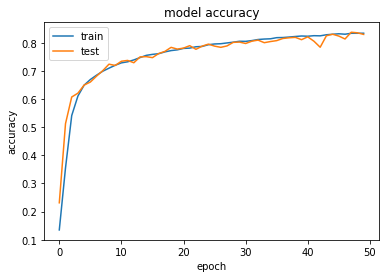

In [27]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Loss Plot

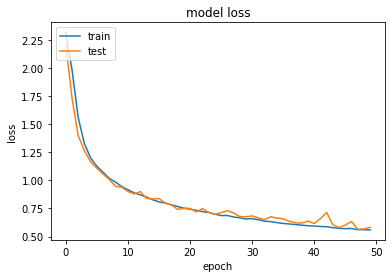

In [28]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [29]:
#Store the Accuracy in a dataframe for final comparison
final_df = pd.DataFrame({'Models':['Adam with one Layer'], 'loss': res1[0], 'Accuracy': res1[1]},index={'1'})
final_df = final_df[['Models','loss', 'Accuracy']]
final_df

,Models,loss,Accuracy
1,Adam with one Layer,0.678502,0.809778


# Using adam Optimizer

In [30]:
tf.keras.backend.clear_session()
mod1b = Sequential()
mod1b.add(Flatten())
mod1b.add(Dense(777, input_shape = (1024,), activation='relu', name='Hidden_Layer_1')) #first hidden layer with 777 neurons, and activation function relu.
mod1b.add(Dense(777, input_shape = (1024,), activation='relu', name='Hidden_Layer_2')) #second hidden layer with 777 neurons, and activation function relu.
mod1b.add(Dense(10, activation='softmax', name='Output_Layer')) #output layer with 10 neurons since we have 10 different classes
adam = optimizers.Adam(lr = 0.001)
mod1b.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy']) # SGD optimizer is used

In [31]:
history_sgd = mod1b.fit(X_train_reNew, y_train, batch_size = 200, validation_data=(X_val_reNew,y_val), epochs = 50, verbose = 1) #50 epochs with batch size 200.

Train on 42000 samples, validate on 60000 samples
Epoch 1/50
42000/42000 [==============================] - 11s 257us/sample - loss: 2.0655 - acc: 0.2555 - val_loss: 1.5394 - val_acc: 0.4986
Epoch 2/50
42000/42000 [==============================] - 11s 260us/sample - loss: 1.3801 - acc: 0.5531 - val_loss: 1.2148 - val_acc: 0.6223
Epoch 3/50
42000/42000 [==============================] - 11s 258us/sample - loss: 1.1675 - acc: 0.6351 - val_loss: 1.0705 - val_acc: 0.6706
Epoch 4/50
42000/42000 [==============================] - 11s 252us/sample - loss: 1.0485 - acc: 0.6746 - val_loss: 0.9820 - val_acc: 0.7029
Epoch 5/50
42000/42000 [==============================] - 11s 252us/sample - loss: 0.9612 - acc: 0.7059 - val_loss: 0.9165 - val_acc: 0.7212
Epoch 6/50
42000/42000 [==============================] - 11s 252us/sample - loss: 0.9186 - acc: 0.7177 - val_loss: 0.9144 - val_acc: 0.7170
Epoch 7/50
42000/42000 [==============================] - 11s 253us/sample - loss: 0.8654 - acc: 0.7347 

In [32]:
mod1b.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            multiple                  0         
_________________________________________________________________
Hidden_Layer_1 (Dense)       multiple                  796425    
_________________________________________________________________
Hidden_Layer_2 (Dense)       multiple                  604506    
_________________________________________________________________
Output_Layer (Dense)         multiple                  7780      
Total params: 1,408,711
Trainable params: 1,408,711
Non-trainable params: 0
_________________________________________________________________


In [33]:
res1b = mod1b.evaluate(X_test_reNew, y_test)

18000/18000 [==============================] - 3s 186us/sample - loss: 0.6289 - acc: 0.8317


In [34]:
Y_pred_cls_2layer = mod1b.predict_classes(X_test_reNew, batch_size=200, verbose=0)

print('Accuracy') 
print( str(mod1b.evaluate(X_test_reNew,y_test)[1]) )

label_2layer=np.argmax(y_test.T, axis=0)
print(confusion_matrix(label_2layer, Y_pred_cls_2layer))
print(classification_report(Y_pred_cls_2layer, label_2layer))

#create evaluation dataframe
stats_2 = pd.DataFrame({'Test accuracy' :  round(res1b[1]*100,3),
                      'F1 score'      : round(f1_score(label_2layer, Y_pred_cls_2layer, average='micro'),3),
                      'ROC AUC score' : round(roc_auc_score(y_test, mod1b.predict_proba(X_test_reNew)),3),
                      'Total Loss'    : round(res1[0],3)}, index=[0])
#print evaluation dataframe
display(stats_2)

Accuracy
18000/18000 [==============================] - 3s 184us/sample - loss: 0.6289 - acc: 0.8317
0.8317222
[[1475   46    6   26   48    9   47   26   52   79]
 [  17 1584   18   21   71    4   21   39   37   16]
 [  10   21 1481   37   47   15   14   82   43   53]
 [  10   41   40 1325   42  103   24   45   59   30]
 [   8   40   20   23 1633    7   27   16   17   21]
 [  13   24   10   75   31 1431   69   12   54   49]
 [  24   17   13   21   58   48 1535   15   90   11]
 [  13   65   36   15   20   13   11 1600   11   24]
 [  18   48   22   37   46   33   95    8 1450   55]
 [  35   37   24   39   53   42   15   22   80 1457]]
              precision    recall  f1-score   support

           0       0.81      0.91      0.86      1623
           1       0.87      0.82      0.84      1923
           2       0.82      0.89      0.85      1670
           3       0.77      0.82      0.79      1619
           4       0.90      0.80      0.85      2049
           5       0.81      0.84

,Test accuracy,F1 score,ROC AUC score,Total Loss
0,83.172,0.832,0.979,0.679


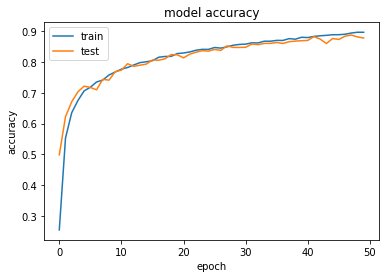

In [35]:
#Accuracy Plot
plt.plot(history_sgd.history['acc'])
plt.plot(history_sgd.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

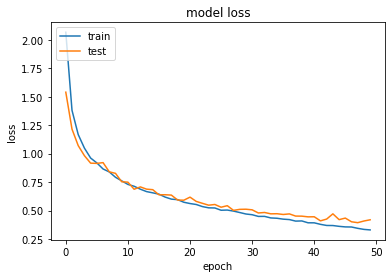

In [36]:
#loss plot

plt.plot(history_sgd.history['loss'])
plt.plot(history_sgd.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [37]:
temp_df = pd.DataFrame({'Models':['Adam with two Layer'],'loss': res1b[0], 'Accuracy': [res1b[1]]},index={'2'})
final_df= pd.concat([final_df, temp_df])
final_df

,Models,loss,Accuracy
1,Adam with one Layer,0.678502,0.809778
2,Adam with two Layer,0.628856,0.831722


# Build NN with 4 hidden layer. 

* 4 hidden layers and activation function as sigmoid 
* adam optimizer with learning rate as 0.01 is used. 
* In this step, we use 100 epochs

In [38]:
tf.keras.backend.clear_session()
mod2 = Sequential()
mod2.add(Flatten())
mod2.add(Dense(50, input_shape = (1024,), activation='sigmoid', name='Hidden_Layer_1')) # First hidden layer  
mod2.add(Dense(50, activation='sigmoid', name='Hidden_Layer_2')) #second hidden layer 
mod2.add(Dense(50, activation='sigmoid', name='Hidden_Layer_3')) #Third hidden layer  
mod2.add(Dense(50, activation='sigmoid', name='Hidden_Layer_4')) #Fourth hidden layer  
mod2.add(Dense(10, activation='softmax', name='Output_Layer')) #output layer  

In [39]:
adam = optimizers.Adam(lr = 0.001)
mod2.compile(optimizer = adam, loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [40]:
history_4L_adm = mod2.fit(X_train_reNew, y_train, batch_size = 200, validation_data=(X_val_reNew,y_val), epochs = 100, verbose = 1)

Train on 42000 samples, validate on 60000 samples
Epoch 1/100
42000/42000 [==============================] - 2s 46us/sample - loss: 2.3103 - acc: 0.1005 - val_loss: 2.3048 - val_acc: 0.1000
Epoch 2/100
42000/42000 [==============================] - 2s 41us/sample - loss: 2.3026 - acc: 0.1070 - val_loss: 2.2950 - val_acc: 0.1274
Epoch 3/100
42000/42000 [==============================] - 2s 40us/sample - loss: 2.2189 - acc: 0.1392 - val_loss: 2.0692 - val_acc: 0.1884
Epoch 4/100
42000/42000 [==============================] - 2s 40us/sample - loss: 1.9980 - acc: 0.2103 - val_loss: 1.9995 - val_acc: 0.2115
Epoch 5/100
42000/42000 [==============================] - 2s 40us/sample - loss: 1.9353 - acc: 0.2376 - val_loss: 1.9065 - val_acc: 0.2430
Epoch 6/100
42000/42000 [==============================] - 2s 40us/sample - loss: 1.8986 - acc: 0.2503 - val_loss: 1.8881 - val_acc: 0.2569
Epoch 7/100
42000/42000 [==============================] - 2s 40us/sample - loss: 1.8685 - acc: 0.2633 - val_l

In [41]:
mod2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            multiple                  0         
_________________________________________________________________
Hidden_Layer_1 (Dense)       multiple                  51250     
_________________________________________________________________
Hidden_Layer_2 (Dense)       multiple                  2550      
_________________________________________________________________
Hidden_Layer_3 (Dense)       multiple                  2550      
_________________________________________________________________
Hidden_Layer_4 (Dense)       multiple                  2550      
_________________________________________________________________
Output_Layer (Dense)         multiple                  510       
Total params: 59,410
Trainable params: 59,410
Non-trainable params: 0
____________________________________________________

In [42]:
res2 = mod2.evaluate(X_test_reNew, y_test)

18000/18000 [==============================] - 1s 39us/sample - loss: 0.8589 - acc: 0.7301


In [43]:
Y_pred_cls_4layer = mod2.predict_classes(X_test_reNew, batch_size=200, verbose=0)

print('Accuracy') 
print( str(mod2.evaluate(X_test_reNew,y_test)[1]) )

label_4layer=np.argmax(y_test.T, axis=0)
print(confusion_matrix(label_4layer, Y_pred_cls_4layer))
print(classification_report(Y_pred_cls_4layer, label_4layer))

#create evaluation dataframe
stats_3 = pd.DataFrame({'Test accuracy' :  round(res2[1]*100,3),
                      'F1 score'      : round(f1_score(label_4layer, Y_pred_cls_4layer, average='micro'),3),
                      'ROC AUC score' : round(roc_auc_score(y_test, mod2.predict_proba(X_test_reNew)),3),
                      'Total Loss'    : round(res2[0],3)}, index=[0])
#print evaluation dataframe
display(stats_3)

Accuracy
18000/18000 [==============================] - 1s 37us/sample - loss: 0.8589 - acc: 0.7301
0.7301111
[[1462   17   25   18   46    6   89    8   74   69]
 [  36 1372   12   65  184   31   16   42   49   21]
 [  62   63 1251   86   31   11    4   94   37  164]
 [  14   52   27 1164   24  270    8   17   78   65]
 [  40   69   15   21 1435   47  112    4   56   13]
 [  13   21   11  107   31 1302   87    2  174   20]
 [  39   21    4   15   88   84 1427    5  136   13]
 [  46  161  151   66   24    9    6 1296   34   15]
 [  47   18    9   43   39  144  166    4 1266   76]
 [ 124   33   37   65   30   50   21   10  267 1167]]
              precision    recall  f1-score   support

           0       0.81      0.78      0.79      1883
           1       0.75      0.75      0.75      1827
           2       0.69      0.81      0.75      1542
           3       0.68      0.71      0.69      1650
           4       0.79      0.74      0.77      1932
           5       0.74      0.67 

,Test accuracy,F1 score,ROC AUC score,Total Loss
0,73.011,0.73,0.956,0.859


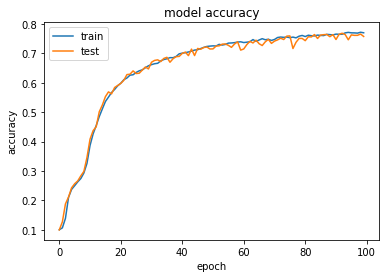

In [44]:
#Accuracy plot
plt.plot(history_4L_adm.history['acc'])
plt.plot(history_4L_adm.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

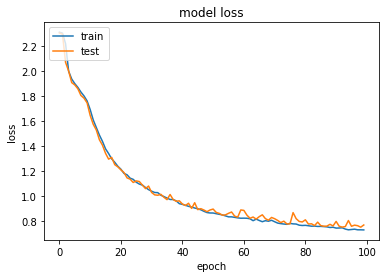

In [45]:
#Loss Plot
plt.plot(history_4L_adm.history['loss'])
plt.plot(history_4L_adm.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [46]:
temp_df = pd.DataFrame({'Models':['adam with 4 Layers'],'loss': res2[0], 'Accuracy': [res2[1]]},index={'3'})
final_df= pd.concat([final_df, temp_df])
final_df

,Models,loss,Accuracy
1,Adam with one Layer,0.678502,0.809778
2,Adam with two Layer,0.628856,0.831722
3,adam with 4 Layers,0.858889,0.730111


* Accuracy level has increased when the model is build with 4 hidden layers, activation function as sigmoid, 
adam optimizer with learning rate as 0.01, and with 100 epochs. 

###  Weight Initialization


Weight initialization scheme can significantly improve training of the model by preventing vanishing gradient problem up to some degree

In [47]:
def mlp_model():
    model = Sequential()
    model.add(Flatten())
    model.add(Dense(50, input_shape = (1024, ), kernel_initializer='uniform'))     # use uniform initializer
    model.add(Activation('sigmoid'))    
    model.add(Dense(50, kernel_initializer='uniform'))                            # use uniform initializer
    model.add(Activation('sigmoid'))    
    model.add(Dense(50, kernel_initializer='uniform'))                            # use uniform initializer
    model.add(Activation('sigmoid'))    
    model.add(Dense(50, kernel_initializer='uniform'))                            # use uniform initializer
    model.add(Activation('sigmoid'))    
    model.add(Dense(10, kernel_initializer='uniform'))                            # use uniform initializer
    model.add(Activation('softmax'))
    
    adam = optimizers.Adam(lr = 0.001)
    model.compile(optimizer = adam, loss = 'categorical_crossentropy', metrics = ['accuracy'])
    
    return model

In [48]:
mod3 = mlp_model()
history_weight_adam = mod3.fit(X_train_reNew, y_train, batch_size = 200, validation_data=(X_val_reNew,y_val), epochs = 100, verbose = 1)

Train on 42000 samples, validate on 60000 samples
Epoch 1/100
42000/42000 [==============================] - 2s 52us/sample - loss: 2.3043 - acc: 0.0993 - val_loss: 2.3039 - val_acc: 0.1000
Epoch 2/100
42000/42000 [==============================] - 2s 42us/sample - loss: 2.3037 - acc: 0.0997 - val_loss: 2.3032 - val_acc: 0.1000
Epoch 3/100
42000/42000 [==============================] - 2s 42us/sample - loss: 2.3033 - acc: 0.0992 - val_loss: 2.3026 - val_acc: 0.1000
Epoch 4/100
42000/42000 [==============================] - 2s 42us/sample - loss: 2.3030 - acc: 0.0993 - val_loss: 2.3027 - val_acc: 0.1000
Epoch 5/100
42000/42000 [==============================] - 2s 42us/sample - loss: 2.3029 - acc: 0.0990 - val_loss: 2.3026 - val_acc: 0.1000
Epoch 6/100
42000/42000 [==============================] - 2s 42us/sample - loss: 2.3028 - acc: 0.1008 - val_loss: 2.3027 - val_acc: 0.1000
Epoch 7/100
42000/42000 [==============================] - 2s 41us/sample - loss: 2.3027 - acc: 0.1013 - val_l

In [49]:
mod3.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  51250     
_________________________________________________________________
activation (Activation)      multiple                  0         
_________________________________________________________________
dense_1 (Dense)              multiple                  2550      
_________________________________________________________________
activation_1 (Activation)    multiple                  0         
_________________________________________________________________
dense_2 (Dense)              multiple                  2550      
_________________________________________________________________
activation_2 (Activation)    multiple                 

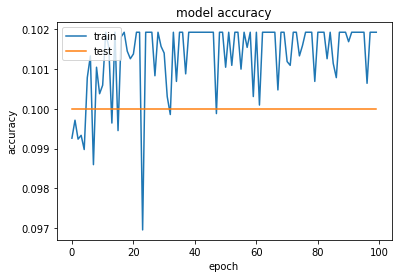

In [50]:
#Accuracy plot
plt.plot(history_weight_adam.history['acc'])
plt.plot(history_weight_adam.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

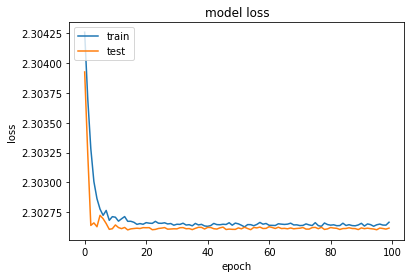

In [51]:
#Loss Plot
plt.plot(history_weight_adam.history['loss'])
plt.plot(history_weight_adam.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [52]:
res3 = mod3.evaluate(X_test_reNew, y_test)

18000/18000 [==============================] - 1s 41us/sample - loss: 2.3028 - acc: 0.0955


In [53]:
Y_pred_cls_5layer = mod3.predict_classes(X_test_reNew, batch_size=200, verbose=0)

print('Accuracy') 
print( str(mod3.evaluate(X_test_reNew,y_test)[1]) )

label_5layer=np.argmax(y_test.T, axis=0)
print(confusion_matrix(label_5layer, Y_pred_cls_5layer))
print(classification_report(Y_pred_cls_5layer, label_5layer))

#create evaluation dataframe
stats_3 = pd.DataFrame({'Test accuracy' :  round(res3[1]*100,3),
                      'F1 score'      : round(f1_score(label_5layer, Y_pred_cls_5layer, average='micro'),3),
                      'ROC AUC score' : round(roc_auc_score(y_test, mod3.predict_proba(X_test_reNew)),3),
                      'Total Loss'    : round(res3[0],3)}, index=[0])
#print evaluation dataframe
display(stats_3)

Accuracy
18000/18000 [==============================] - 1s 40us/sample - loss: 2.3028 - acc: 0.0955
0.0955
[[   0    0    0 1814    0    0    0    0    0    0]
 [   0    0    0 1828    0    0    0    0    0    0]
 [   0    0    0 1803    0    0    0    0    0    0]
 [   0    0    0 1719    0    0    0    0    0    0]
 [   0    0    0 1812    0    0    0    0    0    0]
 [   0    0    0 1768    0    0    0    0    0    0]
 [   0    0    0 1832    0    0    0    0    0    0]
 [   0    0    0 1808    0    0    0    0    0    0]
 [   0    0    0 1812    0    0    0    0    0    0]
 [   0    0    0 1804    0    0    0    0    0    0]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0
           3       1.00      0.10      0.17     18000
           4       0.00      0.00      0.00         0
           5       0.00      0.00    

C:\Users\HI\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Test accuracy,F1 score,ROC AUC score,Total Loss
0,9.55,0.096,0.499,2.303


In [54]:

temp_df = pd.DataFrame({'Models':['Random Weights'],'loss': res3[0], 'Accuracy': [res3[1]]},index={'4'})
final_df= pd.concat([final_df, temp_df])
final_df


,Models,loss,Accuracy
1,Adam with one Layer,0.678502,0.809778
2,Adam with two Layer,0.628856,0.831722
3,adam with 4 Layers,0.858889,0.730111
4,Random Weights,2.302752,0.095500


###  Nonlinearity (Activation function)
Sigmoid functions suffer from gradient vanishing problem, making training slower.
'relu' (rectified linear unit) is one of the most popular ones.

In [55]:
def mlp_model():
    model = Sequential()
    model.add(Flatten())
    model.add(Dense(50, input_shape = (1024, )))
    model.add(Activation('relu'))    
    model.add(Dense(50))
    model.add(Activation('relu'))    
    model.add(Dense(50))
    model.add(Activation('relu'))    
    model.add(Dense(50))
    model.add(Activation('relu'))    
    model.add(Dense(10))
    model.add(Activation('softmax'))
    adam = optimizers.Adam(lr = 0.001)
    model.compile(optimizer = adam, loss = 'categorical_crossentropy', metrics = ['accuracy'])
    
    return model

In [56]:
mod4 = mlp_model()
history_relu = mod4.fit(X_train_reNew, y_train, batch_size = 200, validation_data=(X_val_reNew,y_val), epochs = 100, verbose = 1)

Train on 42000 samples, validate on 60000 samples
Epoch 1/100
42000/42000 [==============================] - 2s 48us/sample - loss: 2.2752 - acc: 0.1230 - val_loss: 2.1653 - val_acc: 0.1786
Epoch 2/100
42000/42000 [==============================] - 2s 46us/sample - loss: 2.0196 - acc: 0.2375 - val_loss: 1.7982 - val_acc: 0.3352
Epoch 3/100
42000/42000 [==============================] - 2s 46us/sample - loss: 1.7020 - acc: 0.3770 - val_loss: 1.5910 - val_acc: 0.4268
Epoch 4/100
42000/42000 [==============================] - 2s 46us/sample - loss: 1.5366 - acc: 0.4578 - val_loss: 1.4816 - val_acc: 0.4905
Epoch 5/100
42000/42000 [==============================] - 2s 46us/sample - loss: 1.4333 - acc: 0.5148 - val_loss: 1.4547 - val_acc: 0.5004
Epoch 6/100
42000/42000 [==============================] - 2s 45us/sample - loss: 1.3606 - acc: 0.5424 - val_loss: 1.3338 - val_acc: 0.5562
Epoch 7/100
42000/42000 [==============================] - 2s 46us/sample - loss: 1.3127 - acc: 0.5603 - val_l

In [57]:
mod4.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          multiple                  0         
_________________________________________________________________
dense_5 (Dense)              multiple                  51250     
_________________________________________________________________
activation_5 (Activation)    multiple                  0         
_________________________________________________________________
dense_6 (Dense)              multiple                  2550      
_________________________________________________________________
activation_6 (Activation)    multiple                  0         
_________________________________________________________________
dense_7 (Dense)              multiple                  2550      
_________________________________________________________________
activation_7 (Activation)    multiple                 

In [58]:
res4= mod4.evaluate(X_test_reNew, y_test)

18000/18000 [==============================] - 1s 42us/sample - loss: 1.0364 - acc: 0.6703


In [59]:
Y_pred_cls_6layer = mod4.predict_classes(X_test_reNew, batch_size=200, verbose=0)

print('Accuracy') 
print( str(mod4.evaluate(X_test_reNew,y_test)[1]) )

label_6layer=np.argmax(y_test.T, axis=0)
print(confusion_matrix(label_6layer, Y_pred_cls_6layer))
print(classification_report(Y_pred_cls_6layer, label_6layer))

#create evaluation dataframe
stats_4 = pd.DataFrame({'Test accuracy' :  round(res4[1]*100,3),
                      'F1 score'      : round(f1_score(label_6layer, Y_pred_cls_6layer, average='micro'),3),
                      'ROC AUC score' : round(roc_auc_score(y_test, mod4.predict_proba(X_test_reNew)),3),
                      'Total Loss'    : round(res4[0],3)}, index=[0])
#print evaluation dataframe
display(stats_4)

Accuracy
18000/18000 [==============================] - 1s 40us/sample - loss: 1.0364 - acc: 0.6703
0.6703333
[[1294   79   56   25   87   15   72   38   33  115]
 [  80 1300   34   59  193   27   21   69   10   35]
 [  67   73 1236   71   89   30   24  132   15   66]
 [  35  105   71 1084   66  175   25   59   65   34]
 [  51   98   17   16 1481   35   51   10   17   36]
 [  60   65   36  165   71 1087  115   20   86   63]
 [  88   66    7   26  153   88 1260   21   85   38]
 [  51  135  153   54   60   26   38 1254    7   30]
 [ 101   96   18   49  118  147  192   24  932  135]
 [ 139  100   51   68   74   82   38   30   84 1138]]
              precision    recall  f1-score   support

           0       0.71      0.66      0.68      1966
           1       0.71      0.61      0.66      2117
           2       0.69      0.74      0.71      1679
           3       0.63      0.67      0.65      1617
           4       0.82      0.62      0.70      2392
           5       0.61      0.63 

,Test accuracy,F1 score,ROC AUC score,Total Loss
0,67.033,0.67,0.935,1.036


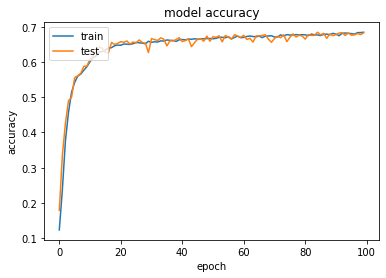

In [60]:
#Accuracy plot
plt.plot(history_relu.history['acc'])
plt.plot(history_relu.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

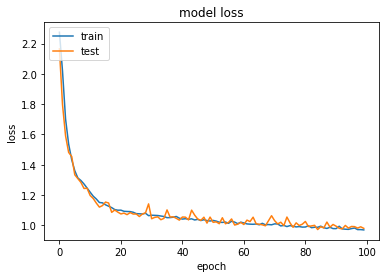

In [61]:
#Loss Plot
plt.plot(history_relu.history['loss'])
plt.plot(history_relu.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [62]:
temp_df = pd.DataFrame({'Models':['Relu'],'loss': res4[0], 'Accuracy': [res4[1]]},index={'5'})
final_df= pd.concat([final_df, temp_df])
final_df

,Models,loss,Accuracy
1,Adam with one Layer,0.678502,0.809778
2,Adam with two Layer,0.628856,0.831722
3,adam with 4 Layers,0.858889,0.730111
4,Random Weights,2.302752,0.095500
5,Relu,1.036408,0.670333


### Batch Normalization

Batch Normalization, one of the methods to prevent the "internal covariance shift" problem, has proven to be highly effective
Normalize each mini-batch before nonlinearity

In [63]:
# Batch normalization with sigmoid as activation function for hidden layers.
def mlp_model():
    model = Sequential()
    model.add(Flatten())
    model.add(Dense(50, input_shape = (1024, )))
    model.add(BatchNormalization())                    
    model.add(Activation('sigmoid'))    
    model.add(Dense(50))
    model.add(BatchNormalization())                    
    model.add(Activation('sigmoid'))    
    model.add(Dense(50))
    model.add(BatchNormalization())                    
    model.add(Activation('sigmoid'))    
    model.add(Dense(50))
    model.add(BatchNormalization())                    
    model.add(Activation('sigmoid'))    
    model.add(Dense(10))
    model.add(Activation('softmax'))
    
    adam = optimizers.Adam(lr = 0.001)
    model.compile(optimizer = adam, loss = 'categorical_crossentropy', metrics = ['accuracy'])

    return model

In [64]:
mod5 = mlp_model()
history_batch = mod5.fit(X_train_reNew, y_train, batch_size = 200, validation_data=(X_val_reNew,y_val), epochs = 100, verbose = 1)

Train on 42000 samples, validate on 60000 samples
Epoch 1/100
42000/42000 [==============================] - 4s 96us/sample - loss: 2.2967 - acc: 0.1649 - val_loss: 2.2988 - val_acc: 0.1186
Epoch 2/100
42000/42000 [==============================] - 2s 59us/sample - loss: 2.1928 - acc: 0.2370 - val_loss: 2.2479 - val_acc: 0.1508
Epoch 3/100
42000/42000 [==============================] - 3s 60us/sample - loss: 1.7385 - acc: 0.4391 - val_loss: 2.0640 - val_acc: 0.2539
Epoch 4/100
42000/42000 [==============================] - 2s 59us/sample - loss: 1.3397 - acc: 0.5983 - val_loss: 1.6285 - val_acc: 0.4034
Epoch 5/100
42000/42000 [==============================] - 2s 59us/sample - loss: 1.1412 - acc: 0.6535 - val_loss: 1.3401 - val_acc: 0.5519
Epoch 6/100
42000/42000 [==============================] - 2s 59us/sample - loss: 1.0344 - acc: 0.6844 - val_loss: 1.2245 - val_acc: 0.6109
Epoch 7/100
42000/42000 [==============================] - 3s 60us/sample - loss: 0.9550 - acc: 0.7089 - val_l

In [65]:
mod5.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          multiple                  0         
_________________________________________________________________
dense_10 (Dense)             multiple                  51250     
_________________________________________________________________
batch_normalization (BatchNo multiple                  200       
_________________________________________________________________
activation_10 (Activation)   multiple                  0         
_________________________________________________________________
dense_11 (Dense)             multiple                  2550      
_________________________________________________________________
batch_normalization_1 (Batch multiple                  200       
_________________________________________________________________
activation_11 (Activation)   multiple                 

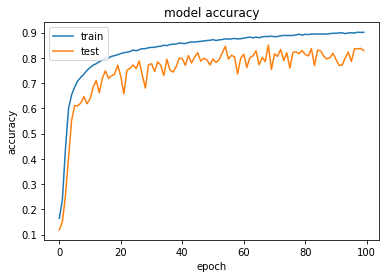

In [66]:
#Accuracy Plot
plt.plot(history_batch.history['acc'])
plt.plot(history_batch.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

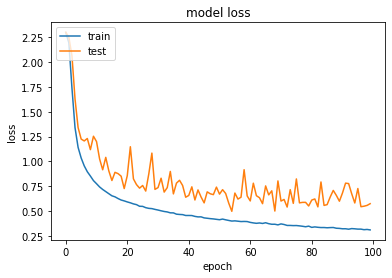

In [67]:
#Loss Plot
plt.plot(history_batch.history['loss'])
plt.plot(history_batch.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [68]:
res5= mod5.evaluate(X_test_reNew, y_test)

18000/18000 [==============================] - 1s 57us/sample - loss: 0.7938 - acc: 0.7856


In [69]:
Y_pred_cls_7layer = mod5.predict_classes(X_test_reNew, batch_size=200, verbose=0)

print('Accuracy') 
print( str(mod5.evaluate(X_test_reNew,y_test)[1]) )

label_7layer=np.argmax(y_test.T, axis=0)
print(confusion_matrix(label_7layer, Y_pred_cls_7layer))
print(classification_report(Y_pred_cls_7layer, label_7layer))

#create evaluation dataframe
stats_5 = pd.DataFrame({'Test accuracy' :  round(res5[1]*100,3),
                      'F1 score'      : round(f1_score(label_7layer, Y_pred_cls_7layer, average='micro'),3),
                      'ROC AUC score' : round(roc_auc_score(y_test, mod5.predict_proba(X_test_reNew)),3),
                      'Total Loss'    : round(res5[0],3)}, index=[0])
#print evaluation dataframe
display(stats_5)

Accuracy
18000/18000 [==============================] - 1s 56us/sample - loss: 0.7938 - acc: 0.7856
0.78555554
[[1387   56   12   66  166   12   38   42   11   24]
 [  12 1430    8   94  175    9   10   69   14    7]
 [   9   23 1335  139   78   18    6  151   17   27]
 [   6   19   21 1447   45   87   21   39   25    9]
 [  13   29   17   46 1648    9   18   11    7   14]
 [   4   14    5  206   50 1350   82   22   24   11]
 [  16   21    5   59  121   72 1449   15   62   12]
 [   6   53   27   71   49   11    4 1577    5    5]
 [  21   35   21  145  103   59   95   27 1271   35]
 [  43   37   30  104  140   87   33   48   36 1246]]
              precision    recall  f1-score   support

           0       0.76      0.91      0.83      1517
           1       0.78      0.83      0.81      1717
           2       0.74      0.90      0.81      1481
           3       0.84      0.61      0.71      2377
           4       0.91      0.64      0.75      2575
           5       0.76      0.79

,Test accuracy,F1 score,ROC AUC score,Total Loss
0,78.556,0.786,0.973,0.794


In [70]:
temp_df = pd.DataFrame({'Models':['sigmoid'],'loss': res5[0], 'Accuracy': [res5[1]]},index={'6'})
final_df= pd.concat([final_df, temp_df])
final_df

,Models,loss,Accuracy
1,Adam with one Layer,0.678502,0.809778
2,Adam with two Layer,0.628856,0.831722
3,adam with 4 Layers,0.858889,0.730111
4,Random Weights,2.302752,0.095500
5,Relu,1.036408,0.670333
6,sigmoid,0.793837,0.785556


### Dropout

In [71]:
def mlp_model():
    model = Sequential()
    model.add(Flatten())
    model.add(Dense(50, input_shape = (1024, ), kernel_initializer='uniform'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(Dense(50, kernel_initializer='uniform'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))    
    model.add(Dropout(0.2))
    model.add(Dense(10, kernel_initializer='uniform'))
    model.add(Activation('softmax'))
    
    adam = optimizers.Adam(lr = 0.001)
    model.compile(optimizer = adam, loss = 'categorical_crossentropy', metrics = ['accuracy'])
    
    return model

In [72]:
mod6 = mlp_model()
history_dropout = mod6.fit(X_train_reNew, y_train, batch_size = 200, validation_data=(X_val_reNew,y_val), epochs = 100, verbose = 1)

Train on 42000 samples, validate on 60000 samples
Epoch 1/100
42000/42000 [==============================] - 4s 84us/sample - loss: 1.8412 - acc: 0.3701 - val_loss: 1.8734 - val_acc: 0.4349
Epoch 2/100
42000/42000 [==============================] - 2s 58us/sample - loss: 1.3338 - acc: 0.5595 - val_loss: 1.4483 - val_acc: 0.5273
Epoch 3/100
42000/42000 [==============================] - 2s 56us/sample - loss: 1.2040 - acc: 0.6053 - val_loss: 1.1609 - val_acc: 0.6603
Epoch 4/100
42000/42000 [==============================] - 2s 57us/sample - loss: 1.1314 - acc: 0.6309 - val_loss: 1.1898 - val_acc: 0.6138
Epoch 5/100
42000/42000 [==============================] - 3s 62us/sample - loss: 1.0888 - acc: 0.6486 - val_loss: 0.9668 - val_acc: 0.7011
Epoch 6/100
42000/42000 [==============================] - 2s 57us/sample - loss: 1.0481 - acc: 0.6627 - val_loss: 1.1119 - val_acc: 0.6466
Epoch 7/100
42000/42000 [==============================] - 2s 55us/sample - loss: 1.0168 - acc: 0.6729 - val_l

In [73]:
mod6.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          multiple                  0         
_________________________________________________________________
dense_15 (Dense)             multiple                  51250     
_________________________________________________________________
batch_normalization_4 (Batch multiple                  200       
_________________________________________________________________
activation_15 (Activation)   multiple                  0         
_________________________________________________________________
dropout (Dropout)            multiple                  0         
_________________________________________________________________
dense_16 (Dense)             multiple                  2550      
_________________________________________________________________
batch_normalization_5 (Batch multiple                 

In [74]:
res6= mod6.evaluate(X_test_reNew, y_test)

18000/18000 [==============================] - 1s 51us/sample - loss: 42.2125 - acc: 0.7140


In [75]:
Y_pred_cls_8layer = mod6.predict_classes(X_test_reNew, batch_size=200, verbose=0)

print('Accuracy') 
print( str(mod6.evaluate(X_test_reNew,y_test)[1]) )

label_8layer=np.argmax(y_test.T, axis=0)
print(confusion_matrix(label_8layer, Y_pred_cls_8layer))
print(classification_report(Y_pred_cls_8layer, label_8layer))

#create evaluation dataframe
stats_6 = pd.DataFrame({'Test accuracy' :  round(res6[1]*100,3),
                      'F1 score'      : round(f1_score(label_8layer, Y_pred_cls_8layer, average='micro'),3),
                      'ROC AUC score' : round(roc_auc_score(y_test, mod6.predict_proba(X_test_reNew)),3),
                      'Total Loss'    : round(res5[0],3)}, index=[0])
#print evaluation dataframe
display(stats_6)

Accuracy
18000/18000 [==============================] - 1s 49us/sample - loss: 0.7742 - acc: 0.7614
0.76144445
[[1459   74  115    8   47    2   13   23   30   43]
 [  39 1532   78    8   83    3    2   51   20   12]
 [  12   30 1586    9   30    3    0   77   22   34]
 [  11   58  179 1048   75   83   20   27  146   72]
 [  16   50   62    4 1589    5    6   20   20   40]
 [  11   36   55  107   44 1177   93   11  127  107]
 [  46   33   46   14  110   39 1291   17  212   24]
 [  27  106  402   10   28    2    4 1201   14   14]
 [  23   44   89   17   72   15   50   14 1405   83]
 [  34   50  113   20   54   24    9   19   63 1418]]
              precision    recall  f1-score   support

           0       0.80      0.87      0.84      1678
           1       0.84      0.76      0.80      2013
           2       0.88      0.58      0.70      2725
           3       0.61      0.84      0.71      1245
           4       0.88      0.75      0.81      2132
           5       0.67      0.87

,Test accuracy,F1 score,ROC AUC score,Total Loss
0,71.4,0.761,0.967,0.794


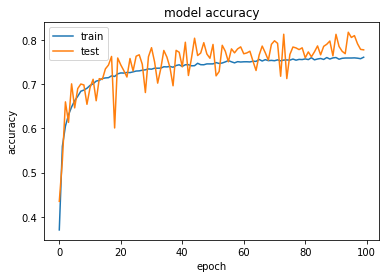

In [76]:
#Accuracy Plot
plt.plot(history_dropout.history['acc'])
plt.plot(history_dropout.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

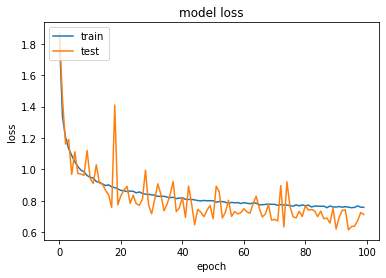

In [77]:
#Loss Plot
plt.plot(history_dropout.history['loss'])
plt.plot(history_dropout.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [78]:
temp_df = pd.DataFrame({'Models':['Dropout'],'loss': res6[0], 'Accuracy': [res6[1]]},index={'7'})
final_df= pd.concat([final_df, temp_df])
final_df

,Models,loss,Accuracy
1,Adam with one Layer,0.678502,0.809778
2,Adam with two Layer,0.628856,0.831722
3,adam with 4 Layers,0.858889,0.730111
4,Random Weights,2.302752,0.095500
5,Relu,1.036408,0.670333
6,sigmoid,0.793837,0.785556
7,Dropout,42.212529,0.714000


# Tuning

In [79]:
tf.keras.backend.clear_session()

mod_tune = Sequential() 
mod_tune.add(Flatten())#Flatten layer
mod_tune.add(Dense(800, kernel_initializer='he_normal')) #First hidden layer with  neurons, equal to input neurons. 
mod_tune.add(BatchNormalization()) 
mod_tune.add(LeakyReLU(alpha=0.05)) #activation function Leakyrelu.
mod_tune.add(Dropout(0.3)) 

mod_tune.add(Dense(800, kernel_initializer='he_normal')) #Second hidden layer with  neurons. 
mod_tune.add(BatchNormalization()) 
mod_tune.add(LeakyReLU(alpha=0.05)) #activation function Leakyrelu.
mod_tune.add(Dropout(0.3))

mod_tune.add(Dense(10)) #output layer with 10 neurons since we have 10 different classes
mod_tune.add(Activation('softmax'))

mod_tune.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
 
history_tune = mod_tune.fit(X_train_reNew, y_train, batch_size = 200, validation_data=(X_val_reNew,y_val), epochs = 100) #200 epochs with batch size 200.

Train on 42000 samples, validate on 60000 samples
Epoch 1/100
42000/42000 [==============================] - 10s 227us/sample - loss: 1.6417 - acc: 0.4513 - val_loss: 1.7864 - val_acc: 0.4108
Epoch 2/100
42000/42000 [==============================] - 9s 211us/sample - loss: 1.0796 - acc: 0.6562 - val_loss: 1.2878 - val_acc: 0.5895
Epoch 3/100
42000/42000 [==============================] - 9s 212us/sample - loss: 0.9328 - acc: 0.7096 - val_loss: 1.3429 - val_acc: 0.5642
Epoch 4/100
42000/42000 [==============================] - 9s 212us/sample - loss: 0.8404 - acc: 0.7375 - val_loss: 1.0176 - val_acc: 0.6730
Epoch 5/100
42000/42000 [==============================] - 9s 215us/sample - loss: 0.7812 - acc: 0.7585 - val_loss: 1.1008 - val_acc: 0.6415
Epoch 6/100
42000/42000 [==============================] - 9s 211us/sample - loss: 0.7317 - acc: 0.7747 - val_loss: 0.9185 - val_acc: 0.7099
Epoch 7/100
42000/42000 [==============================] - 9s 208us/sample - loss: 0.7018 - acc: 0.7823

In [80]:
mod_tune.summary()
res_tune= mod_tune.evaluate(X_test_reNew, y_test)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  512500    
_________________________________________________________________
batch_normalization (BatchNo multiple                  2000      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      multiple                  0         
_________________________________________________________________
dropout (Dropout)            multiple                  0         
_________________________________________________________________
dense_1 (Dense)              multiple                  250500    
_________________________________________________________________
batch_normalization_1 (Batch multiple                  2

In [81]:
Y_pred_cls_tune = mod_tune.predict_classes(X_test_reNew, batch_size=200, verbose=0)

print('Accuracy') 
print( str(mod_tune.evaluate(X_test_reNew,y_test)[1]) )


label_tune=np.argmax(y_test.T, axis=0)
print(confusion_matrix(label_tune, Y_pred_cls_tune))
print(classification_report(Y_pred_cls_tune, label_tune))

#calculate evaluation parameters
f1_tune = f1_score(label_tune, Y_pred_cls_tune, average='micro')
roc_tune = roc_auc_score(y_test, mod_tune.predict_proba(X_test_reNew))
#create evaluation dataframe
stats_tune = pd.DataFrame({'Test accuracy' :  round(res_tune[1]*100,3),
                      'F1 score'      : round(f1_tune,3),
                      'ROC AUC score' : round(roc_tune,3),
                      'Total Loss'    : round(res_tune[0],3)}, index=[0])
#print evaluation dataframe
display(stats_tune)

Accuracy
18000/18000 [==============================] - 3s 155us/sample - loss: 0.7977 - acc: 0.7729
0.77294445
[[1245   18    3   95   11   21  223    7  149   42]
 [  11 1247   18  202   41   82   35   14  168   10]
 [   2    6 1405  209    5   34   12    9  100   21]
 [   4    6   11 1458    4  145   16    2   68    5]
 [   5   23   14   82 1390   49   98    4  123   24]
 [   2    4    7  113    3 1501   47    1   76   14]
 [   9    5    6   41    5   98 1514    2  142   10]
 [   7   42   53  334   10   43   22 1230   52   15]
 [   5    9    5   88    2   43   77    1 1565   17]
 [  11    7   11  102   10   88   45    7  165 1358]]
              precision    recall  f1-score   support

           0       0.69      0.96      0.80      1301
           1       0.68      0.91      0.78      1367
           2       0.78      0.92      0.84      1533
           3       0.85      0.54      0.66      2724
           4       0.77      0.94      0.84      1481
           5       0.85      0.7

,Test accuracy,F1 score,ROC AUC score,Total Loss
0,77.294,0.773,0.977,0.798


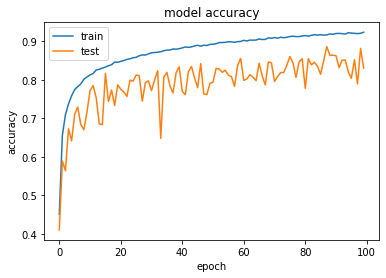

In [82]:
#Accuracy plot
plt.plot(history_tune.history['acc'])
plt.plot(history_tune.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()



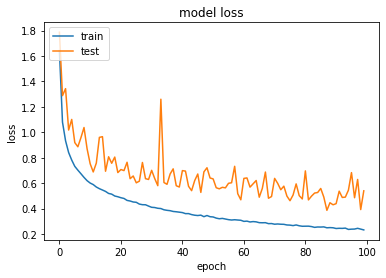

In [83]:
#Loss Plot
plt.plot(history_tune.history['loss'])
plt.plot(history_tune.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()



In [90]:
#Store the Accuracy in a dataframe for final comparison
tuned_df = pd.DataFrame({'Models':['Adam with tuning'], 'loss': res_tune[0], 'Accuracy': res_tune[1]},index={'8'})
tuned_df

,Models,loss,Accuracy
8,Adam with tuning,0.797687,0.772944


# Conclusion

Conclusion:
The assignment is to build a Neural network to classify the labels in SVHN image dataset.

SVHN dataset contains 42000, 18000 and 60000 images of Train, Validation and Test set respectively. Input images are having additional numbers present in Left or right side. These images can be cropped without loosing the actual data.

1 layer NN gives 80% of accuracy,
2 layer NN(83%) gives more accuracy than 1 layered NN(80%).
After that I tried with different combination for tuning the Neural networks and achieved 80% of accuracy.
*NN gives more accuracy when we tune the parmaters with multiple combination like activations functions, epochs, batch size, optimizers etc *.,